인공지능과 가위바위보 하기
=============

 이미지를 가위, 바위, 보 3가지로 분류하는 간단한 인공지능을 만들어 보기
 
 1. 데이터 준비 
 2. 딥러닝 네트워크 설계 
 3. 학습
 4. 테스트(평가)

순서대로 만들어 봅니다. 

## 1. 데이터 준비

### 데이터 만들기

구글의 teachable machine 사이트에서 쉽게 데이터를 만들 수 있었습니다.    
https://teachablemachine.withgoogle.com/

### 데이터 불러오기 + Resize 하기

In [1]:
# resize 하기 위한 라이브러리를 불러오기
from PIL import Image
import os, glob

In [2]:
# 만든 이미지를 불러와서 28x28 사이즈로 변경하는 함수
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

In [ ]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 resize
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/E1/rock_scissor_paper_test/scissor"
resize_images(image_dir_path)

In [ ]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 resize
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/E1/rock_scissor_paper_test/rock"
resize_images(image_dir_path)

In [ ]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 resize
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/E1/rock_scissor_paper_test/paper"
resize_images(image_dir_path)

### 가위, 바위, 보 데이터를 읽기

In [3]:
import numpy as np

# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수
def load_data(img_path, number_of_data=300):  
    # 가위바위보 이미지 개수 총합에 주의
    # 가위: 0, 바위: 1, 보: 2
    img_size=28
    color=3
    # 이미지 데이터와 라벨(가위:0, 바위:1, 보:2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

- load_data() 함수는 입력으로 이미지가 있는 폴더 위치(rock_scissor_paper 폴더 위치)를 적어주면 됩니다. 
- 가위바위보의 경우 3개의 클래스(가위: 0, 바위: 1, 보: 2) 로 라벨링

In [4]:
# train 데이터 읽기 
# train data directory : /aiffel/Exploration/E1/rock_scissor_paper
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/E1/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path, 9300) # 이미지 개수에 맞게 넣어주기
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 9300 입니다.
x_train shape: (9300, 28, 28, 3)
y_train shape: (9300,)


라벨:  0


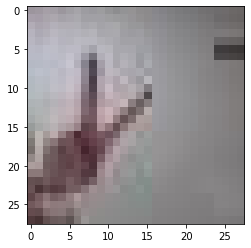

In [5]:
# 이미지 미리보기
import matplotlib.pyplot as plt

plt.imshow(x_train[300])
print('라벨: ', y_train[300])

## 2. 딥러닝 네트워크 설계하기

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16 # 얼마나 다양한 이미지의 특징을 살펴볼지
n_channel_2=32
n_dense=32     # 분류기의 알고리즘을 얼마나 복잡하게 할지
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

## 3. 딥러닝 네트워크 학습시키기

In [7]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
291/291 [==============================] - 6s 10ms/step - loss: 1.0643 - accuracy: 0.4175
Epoch 2/10
291/291 [==============================] - 1s 3ms/step - loss: 0.7783 - accuracy: 0.6445
Epoch 3/10
291/291 [==============================] - 1s 3ms/step - loss: 0.5108 - accuracy: 0.8077
Epoch 4/10
291/291 [==============================] - 1s 3ms/step - loss: 0.3560 - accuracy: 0.8766
Epoch 5/10
291/291 [==============================] - 1s 3ms/step - loss: 0.2658 - accuracy: 0.9083
Epoch 6/10
291/291 [==============================] - 1s 3ms/step - loss: 0.2000 - accuracy: 0.9326
Epoch 7/10
291/291 [==============================] - 1s 3ms/step - loss: 0.1478 - accuracy: 0.9526
Epoch 8/10
291/291 [==============================] - 1s 3ms/step - loss: 0.1228 - accuracy: 0.9624
Epoch 9/10
291/291 [==============================] - 1s 3ms/step - loss: 0.1059 - accuracy: 0.9648
Epoch 10/10
291/291 [==============================] - 1s 3ms/step - loss: 0.0705 - accuracy: 0.979

## 4. 얼마나 잘 만들었는지 확인하기(테스트)

In [8]:
# 테스트용 데이터인 x_test, y_test를 만들기
# test data directory : /aiffel/Exploration/E1/rock_scissor_paper_test
image_dir_path = os.getenv("HOME") + "/aiffel/Exploration/E1/rock_scissor_paper_test"
(x_test, y_test)=load_data(image_dir_path, 600)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

데이터의 이미지 개수는 600 입니다.
x_test shape: (600, 28, 28, 3)
y_test shape: (600,)


### 위에서 훈련시킨 model을 사용하여 test_accuracy를 측정해보기

In [9]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 1s - loss: 0.4626 - accuracy: 0.8450
test_loss: 0.46257704496383667 
test_accuracy: 0.8450000286102295


## 회고

- 이미지 분류기 모델이 성공적으로 만들어졌는가?    
    keras의 Sequential 모델을 사용하여 순차적으로 총 7개의 레이어 층을 더해 주었습니다.    
    다양한 파라미터 값을 변경해 주면서 모델을 학습시켰습니다.     
    이 분류기 모델을 정확하게 이해하지는 못하여 관련 사항은 더 공부해야 할 것 같습니다.     
              
              
- 오버 피팅을 극복하기 위한 적절한 시도가 있었는가?    
    트레인 데이터셋을 가위, 바위, 보 각각 3200개씩, 테스트 데이터셋은 각각 200개씩 넣어 사용하였습니다.     
    데이터는 Min-Max Normalization(최소-최대 정규화)를 사용하여 최대값-최소값(255-0)으로 나누어 0~1 사이의 값으로 정규화하였습니다.     
     
     
- 분류 모델의 test accuracy가 기준 이상 높게 나왔는가?   
    test accuracy 60% 이상 달성하기 위하여 
    트레인 데이터셋을 900, 2100, 6792, 9300개 순으로 학습했을 때 점점 test accuracy 값이 오르긴 하였으나 여전히 낮게 나왔습니다.      
    테스트 데이터셋의 문제라고 생각하여 변경해 주었습니다.     
    최종 84.5%의 test accuracy에 도달하였습니다. 
    